# Imports

In [1]:
#%pip install xgboost

  Using cached xgboost-1.6.0.tar.gz (775 kB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [1138 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build/lib.macosx-10.9-x86_64-3.8
      creating build/lib.macosx-10.9-x86_64-3.8/xgboost
      copying xgboost/rabit.py -> build/lib.macosx-10.9-x86_64-3.8/xgboost
      copying xgboost/callback.py -> build/lib.macosx-10.9-x86_64-3.8/xgboost
      copying xgboost/config.py -> build/lib.macosx-10.9-x86_64-3.8/xgboost
      copying xgboost/compat.py -> build/lib.macosx-10.9-x86_64-3.8/xgboost
      copying xgboost/_typing.py -> build/lib.macosx-10.9-x86_64-3.8/xgboost
      copying xgboost/plotting.py -> build/lib.macosx-10.9-x86_64-3.8/xgboost
      copying xgboost/__init__.py -> build/lib.macosx-10.9-x86_64-3.8/xgboost
      copying xgboost/core.py -> buil

In [25]:
from datetime import datetime as dt
import numpy as np
import pandas as pd
import warnings
import os
import logging
import sys
warnings.filterwarnings('ignore')

In [26]:
import statsmodels.api as sm
import statsmodels.graphics as smg
import statsmodels.stats as sm_stats
import statsmodels.tsa.api as tsa

In [27]:
#metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

In [28]:
import optuna

In [29]:
#visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [30]:
import sklearn

In [31]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor

In [32]:
#from tqdm import tqdm
from tqdm.notebook import tqdm, tqdm_notebook, tnrange
from tqdm import trange

# Functions

In [33]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mape = mean_absolute_percentage_error(actual, pred)
    r2 = r2_score(actual, pred)
    return {'rmse': rmse, 'mae': mae, 'mape': mape, 'r2':r2}

## Preprocessing

Data cleaning 

In [34]:
country = 'Brazil'
#country = 'US'
#country = country_selection.value

In [35]:
df = pd.read_csv('../Data/'+country+"_daily.csv", index_col=0)

In [36]:
end = dt(year=2021, month=12, day=31)

In [37]:
df.index = pd.to_datetime(df.index)
df2 = df.loc[pd.date_range(start=end, end='2022-02-20')]
df = df.loc[pd.date_range(start='2020-01-22', end=end)]

In [38]:
def fix_outliers(df,q = .99, zero = True):
  # cortar período inicial sem casos
  for k,d in enumerate(df):
    if k > 0 and d > df.iloc[k-1]:
      break
  df = df.iloc[k:]
  # substituir zeros
  if zero == False:
    df = df.mask(df == 0, np.nan).fillna(method='bfill')
  # converter valores extremos para NaN e substituir pelo anterior
  df = df.mask(df > df.quantile(q), np.nan).fillna(method='bfill')
  df = df.mask(df < 0, np.nan).fillna(0)
  return df

In [39]:
data = fix_outliers(df)

In [40]:
data2 = fix_outliers(df2)

In [41]:
train_data = data.iloc[:int(len(data)*0.7)] 
val_data = data.iloc[int(len(data)*0.7):int(len(data)*0.9)]
test_data = data.iloc[-int(len(data)*0.1):]

# Split

In [42]:
X_train = pd.DataFrame(tsa.add_lag(train_data, lags =14))
#X_train = pd.DataFrame(tsa.add_lag(train_data.diff().dropna(), lags =14))
y_train = X_train.pop(0)

In [43]:
X_val = pd.DataFrame(tsa.add_lag(val_data, lags =14))
#X_train = pd.DataFrame(tsa.add_lag(train_data.diff().dropna(), lags =14))
y_val = X_val.pop(0)

In [44]:
#X_test = pd.DataFrame(tsa.add_lag(test_data, lags =14))
X_test = pd.DataFrame(tsa.add_lag(test_data, lags =14))
y_test = X_test.pop(0)

# Normalização

In [45]:
#X_train_sd = ((X_train - train_data.mean())/train_data.std()).values.reshape(-1,14,1)
#X_val_sd = ((X_val - train_data.mean())/train_data.std()).values.reshape(-1,14,1)
#X_test_sd = ((X_test - train_data.mean())/train_data.std()).values.reshape(-1,14,1)

In [46]:
min_value = float(train_data.min())
base = float(train_data.max()) - float(train_data.min())

X_train_mm = (X_train - min_value)/base
X_val_mm = (X_val - min_value)/base
X_test_mm = (X_test - min_value)/base

In [47]:
X_train_mm

,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477,0.904424,0.834500,0.422429,0.433869,0.765241,0.863691,0.939837,0.904627,0.843111,0.401217,0.423376,0.759098,0.878152,0.902001
478,0.727315,0.904424,0.834500,0.422429,0.433869,0.765241,0.863691,0.939837,0.904627,0.843111,0.401217,0.423376,0.759098,0.878152
479,0.607360,0.727315,0.904424,0.834500,0.422429,0.433869,0.765241,0.863691,0.939837,0.904627,0.843111,0.401217,0.423376,0.759098
480,0.855035,0.607360,0.727315,0.904424,0.834500,0.422429,0.433869,0.765241,0.863691,0.939837,0.904627,0.843111,0.401217,0.423376


In [24]:
pd.DataFrame(tsa.add_lag(train_data, lags =14))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477,64531.0,80245.0,74041.0,37480.0,38495.0,67896.0,76631.0,83387.0,80263.0,74805.0,35598.0,37564.0,67351.0,77914.0,80030.0
478,53888.0,64531.0,80245.0,74041.0,37480.0,38495.0,67896.0,76631.0,83387.0,80263.0,74805.0,35598.0,37564.0,67351.0,77914.0
479,75863.0,53888.0,64531.0,80245.0,74041.0,37480.0,38495.0,67896.0,76631.0,83387.0,80263.0,74805.0,35598.0,37564.0,67351.0
480,41449.0,75863.0,53888.0,64531.0,80245.0,74041.0,37480.0,38495.0,67896.0,76631.0,83387.0,80263.0,74805.0,35598.0,37564.0


# XGBoost


In [49]:
!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 775.4/775.4 KB 2.0 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
anceled
ERROR: Operation cancelled by user


In [48]:
import xgboost as xgb

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
def objective(trial):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_val, label=y_val)

    param = {
        "verbosity": 0,
        "objective": "reg:squarederror",
        # use exact for small dataset.
        "tree_method": "hist",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "reg_lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "reg_alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["learning_rate"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    pred_labels = preds
    mse = sklearn.metrics.mean_squared_error(y_val, pred_labels)
    return mse

In [27]:
def objective(trial):
    svr_k = trial.suggest_categorical('kernel',['linear', 'rbf'])
    #svr_k = trial.suggest_categorical('kernel',['rbf'])
    svr_g = trial.suggest_float("gamma", 0.001, 1000, log=True)
    svr_c = trial.suggest_float("C", 0.0001, 10000, log=True)
    svr_e = trial.suggest_float("epsilon",0.001, 0.1, log=True)
    svr_t = trial.suggest_float("tolerance", 0.0001, 0.01, log=True)
    regressor_obj = sklearn.svm.SVR(kernel=svr_k, gamma=svr_g, C=svr_c, epsilon=svr_e, tol=svr_t)

    score = sklearn.model_selection.cross_val_score(regressor_obj, X_train_mm.append(X_val_mm), y_train.append(y_val),
                                                    n_jobs=-1, cv=TimeSeriesSplit(2, test_size=len(y_val)//2),
                                                    scoring='neg_root_mean_squared_error').mean()

    #score = sklearn.model_selection.cross_val_score(regressor_obj, X_train.append(X_val), y_train.append(y_val),\
    #                                                n_jobs=-1, cv=TimeSeriesSplit(2, test_size=len(y_val)//2),\
    #                                                scoring='neg_root_mean_squared_error').mean()

    return score

In [28]:
# Add stream handler of stdout to show the messages
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
optuna.logging.set_verbosity(0)
study_name = "xgb-study-"+country  # Unique identifier of the study.
storage_name = "sqlite:///db/{}.db".format(study_name)

In [29]:
%%time
study = optuna.create_study(direction="maximize", study_name=study_name, storage=storage_name)
study.optimize(objective, n_trials=100, show_progress_bar=True)
print(study.best_trial)

100%|██████████| 100/100 [01:06<00:00,  1.50it/s]

FrozenTrial(number=95, values=[-6339.457725427001], datetime_start=datetime.datetime(2022, 5, 5, 16, 20, 21, 260848), datetime_complete=datetime.datetime(2022, 5, 5, 16, 20, 21, 932107), params={'C': 9898.395462923118, 'epsilon': 0.001062089359984648, 'gamma': 0.0017172013778103633, 'kernel': 'linear', 'tolerance': 0.0030186861558076246}, distributions={'C': LogUniformDistribution(high=10000.0, low=0.0001), 'epsilon': LogUniformDistribution(high=0.1, low=0.001), 'gamma': LogUniformDistribution(high=1000.0, low=0.001), 'kernel': CategoricalDistribution(choices=('linear', 'rbf')), 'tolerance': LogUniformDistribution(high=0.01, low=0.0001)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=96, state=TrialState.COMPLETE, value=None)
CPU times: user 21.8 s, sys: 3.62 s, total: 25.4 s
Wall time: 1min 8s


In [30]:
importance = optuna.importance.get_param_importances(study)

<AxesSubplot:title={'center':'importance'}>

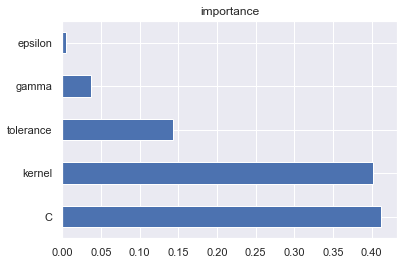

In [31]:
pd.Series(importance).plot.barh(title='importance')

In [32]:
params = study.best_params
params

{'C': 9898.395462923118,
 'epsilon': 0.001062089359984648,
 'gamma': 0.0017172013778103633,
 'kernel': 'linear',
 'tolerance': 0.0030186861558076246}

In [33]:
best_svr = SVR(kernel=params['kernel'], C=params['C'], epsilon=params['epsilon'], tol=params['tolerance'])

In [34]:
%%time
best_svr.fit(X_train_mm, y_train)

CPU times: user 1.98 s, sys: 70.8 ms, total: 2.05 s
Wall time: 3.48 s


SVR(C=9898.395462923118, epsilon=0.001062089359984648, kernel='linear',
    tol=0.0030186861558076246)

In [35]:
metrics = eval_metrics(y_test, best_svr.predict(X_test_mm))
metrics

{'rmse': 2235.039319841934,
 'mae': 1730.259360750754,
 'mape': 0.30461156063287054,
 'r2': 0.6775534964376055}

<AxesSubplot:>

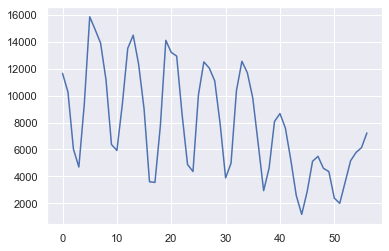

In [36]:
pd.Series(best_svr.predict(X_test_mm)).plot()

In [37]:
from sqlalchemy import create_engine
engine = create_engine("sqlite:///db/{}.db".format(study_name))

In [38]:
tables = pd.read_sql("SELECT name FROM sqlite_schema WHERE type ='table' AND name NOT LIKE 'sqlite_%';", engine)
tables

,name
0,studies
1,version_info
2,study_directions
3,study_user_attributes
4,study_system_attributes
5,trials
6,trial_user_attributes
7,trial_system_attributes
8,trial_params
9,trial_values


In [39]:
trials = pd.read_sql("SELECT * FROM trials T \
    JOIN trial_values TV ON T.trial_id = TV.trial_id \
    JOIN trial_params TP ON T.trial_id = TP.trial_id;", engine)
trials


,trial_id,number,study_id,state,datetime_start,datetime_complete,trial_value_id,trial_id,objective,value,param_id,trial_id,param_name,param_value,distribution_json
0,1,0,1,COMPLETE,2022-05-05 16:19:17.567900,2022-05-05 16:19:28.065393,1,1,0,-19643.680263,1,1,kernel,0.000000,"{""name"": ""CategoricalDistribution"", ""attribute..."
1,1,0,1,COMPLETE,2022-05-05 16:19:17.567900,2022-05-05 16:19:28.065393,1,1,0,-19643.680263,2,1,gamma,0.134400,"{""name"": ""LogUniformDistribution"", ""attributes..."
2,1,0,1,COMPLETE,2022-05-05 16:19:17.567900,2022-05-05 16:19:28.065393,1,1,0,-19643.680263,3,1,C,0.905187,"{""name"": ""LogUniformDistribution"", ""attributes..."
3,1,0,1,COMPLETE,2022-05-05 16:19:17.567900,2022-05-05 16:19:28.065393,1,1,0,-19643.680263,4,1,epsilon,0.011394,"{""name"": ""LogUniformDistribution"", ""attributes..."
4,1,0,1,COMPLETE,2022-05-05 16:19:17.567900,2022-05-05 16:19:28.065393,1,1,0,-19643.680263,5,1,tolerance,0.000305,"{""name"": ""LogUniformDistribution"", ""attributes..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,100,99,1,COMPLETE,2022-05-05 16:20:23.612878,2022-05-05 16:20:24.164980,100,100,0,-6435.719126,496,100,kernel,0.000000,"{""name"": ""CategoricalDistribution"", ""attribute..."
496,100,99,1,COMPLETE,2022-05-05 16:20:23.612878,2022-05-05 16:20:24.164980,100,100,0,-6435.719126,497,100,gamma,0.001318,"{""name"": ""LogUniformDistribution"", ""attributes..."
497,100,99,1,COMPLETE,2022-05-05 16:20:23.612878,2022-05-05 16:20:24.164980,100,100,0,-6435.719126,498,100,C,6184.419166,"{""name"": ""LogUniformDistribution"", ""attributes..."
498,100,99,1,COMPLETE,2022-05-05 16:20:23.612878,2022-05-05 16:20:24.164980,100,100,0,-6435.719126,499,100,epsilon,0.001875,"{""name"": ""LogUniformDistribution"", ""attributes..."
